## Prerequisites

### Load Qiskit and Required Libraries

In [3]:
run_experiment = False

from qiskit import IBMQ, transpile, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate, YGate
from qiskit.pulse import DriveChannel
import qiskit.quantum_info as qi

from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

from qiskit.opflow import (I, X, Y, Z, Zero, One, MatrixEvolution, PauliTrotterEvolution, Suzuki,
                           StateFn, Zero, One, PauliExpectation, PauliOp, SummedOp, OperatorBase)

from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import TemplateOptimization, ALAPSchedule, DynamicalDecoupling
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder, rzx_templates

from qiskit.converters import circuit_to_dag, dag_to_circuit # for bespoke transpilation
from qiskit.dagcircuit import DAGCircuit, DAGNode

from qiskit.scheduler.config import ScheduleConfig
from qiskit.visualization import plot_circuit_layout, plot_error_map, timeline_drawer, dag_drawer

from copy import deepcopy
import numpy as np
import scipy.linalg as lng
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]

### Load IBM Quantum Account
Try Nick's then John's.

In [5]:
IBMQ.load_account()
try:
    provider = IBMQ.get_provider(hub='ibm-q-internal', group='mission-critical', project='bronn')
    backend = provider.get_backend('ibm_lagos')
except:
    provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
    backend = provider.get_backend('ibmq_bogota') # checking gate directions

ibmqfactory.load_account:WARNING:2022-02-28 18:04:17,027: Credentials are already in use. The existing account in the session will be replaced.


### Load Backend Information (for Pulse)

In [3]:
backend_config = backend.configuration()
dt = backend_config.dt
meas_map = backend_config.meas_map

backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

sched_config = ScheduleConfig(inst_sched_map, meas_map, dt)

# Build Circuits from Model Hamiltonian

## Define the System Hamiltonian

John wrote down the system Hamiltonian as

$$ H = \mu\sum_{i=0}^N c^{\dagger}_i c_i + t \sum_{i=0}^{N-1} (c^{\dagger}_ic_{i+1} + c^{\dagger}_{i+1}c_i) + \Delta \sum_{i=0}^{N-1}(c^{\dagger}_i c^{\dagger}_{i+1} + c_{i+1}c_i) + U \sum_{i=0}^{N-1} c^{\dagger}_i c_i c^{\dagger}_{i+1} c_{i+1} $$

where we can use the new `FermionicOp` class to write this general Hamiltonian for 2 site.

In terms of Majorana operators $\gamma^x_i = c^{\dagger}_i + c_i$ and $\gamma^y_i = i(c^{\dagger}_i - c_i)$ we have

$$ H = -\frac{2\mu + U}{4} \sum_{i=0}^N\gamma^x_i\gamma^y_i + \frac{t+\Delta}{2}\sum_{i=0}^{N-1} \gamma^x_i\gamma^y_{i+1} + \frac{t-\Delta}{2} \sum_{i=0}^{N-1} \gamma^y_i\gamma^x_{i+1} + \frac{U}{4}  \sum_{i=0}^{N-1}\gamma^x_i\gamma^y_i\gamma^x_{i+1}\gamma^y_{i+1}$$

In [4]:
hm = sum(FermionicOp(label) for label in ['IN', 'NI'])
ht = FermionicOp('+-') - FermionicOp('-+')
hD = FermionicOp('++') - FermionicOp('--')
hU = sum(FermionicOp(label) for label in ['NN'])

<ipython-input-4-9e352dd89e7e>:1: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  hm = sum(FermionicOp(label) for label in ['IN', 'NI'])


### Transform Fermionic to Pauli Hamiltonian
Bravyi-Kitaev and BKSuperFast are also built into Qiskit.

In [5]:
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper) # should not give 2-qubit reduction error

# parameters defined here due to incompatibility with Qiskit Nature
mu = Parameter('μ')
TT = Parameter('T')
DD = Parameter('Δ')
UU = Parameter('U')

hm_pauli = mu*(converter.convert(hm))
ht_pauli = TT*(converter.convert(ht))
hD_pauli = DD*(converter.convert(hD))
hU_pauli = UU*(converter.convert(hU))

ham_pauli = hm_pauli + ht_pauli + hD_pauli + hU_pauli
print(ham_pauli)

SummedOp([
  1.0*μ * (
    1.0 * II
    - 0.5 * ZI
    - 0.5 * IZ
  ),
  1.0*T * (
    0.5 * XX
    + 0.5 * YY
  ),
  1.0*Δ * (
    0.5 * XX
    - 0.5 * YY
  ),
  1.0*U * (
    0.25 * II
    - 0.25 * ZI
    - 0.25 * IZ
    + 0.25 * ZZ
  )
])


## Build Resonance Hamiltonian

Converting John's notation to little-endian:
$$H = -\frac{1}{2}\omega IIZ + H_{\rm Pauli}\otimes I + c IXX$$
Parsing in `opflow` is very dependent on how you build Hamiltonian.

In [6]:
cc = Parameter('c')
ww = Parameter('ω')

def build_resonance_ham(h0: OperatorBase) -> SummedOp:
    nq = h0.num_qubits
    h_jw = []
    for op in h0:
        for pop in op:
            h_jw.append((pop^I).to_pauli_op())
    oplist = [-0.5*ww*((I^(nq))^Z), cc*((I^(nq-1))^X^X)]
    oplist += h_jw
    return SummedOp(oplist)

## Time Evolve Resonance Hamiltonian

In [7]:
tt = Parameter('t')
res_ham = build_resonance_ham(ham_pauli)
U_ham = (tt*res_ham).exp_i()
#print(U_ham)

## Trotterize Unitary Evolution Operator
Why do random subcircuit appear sometimes? One hypothesis: parsing each coefficient with `Parameter`s expanded vs being multiplied by a grouping of `PauliOp`s might be it (observed this behavior at Heidelberg workshop).

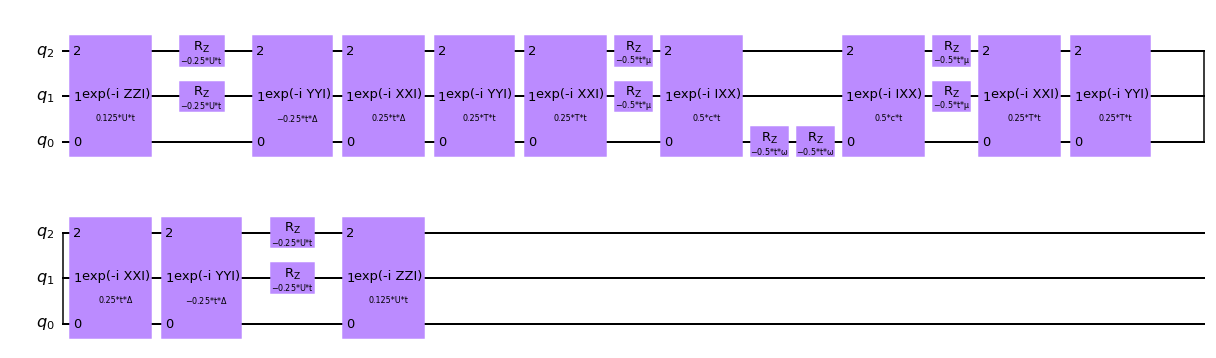

In [8]:
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(U_ham)
trot_circ = trot_op.to_circuit()
trot_circ.draw(output='mpl', reverse_bits=True)

# Transpile Circuits to Quantum Backend

## *Incredibly* useful notes on what we're doing

Transpilation will take place "by hand" so that we can introduce the template optimization at the correct point. Each *pass* of the transpiler is classified as either an analysis or transformation pass. Template optimization consists of two passes:
- `TemplateOptimization` is an analysis pass that adds the templates (similar to circuit equivalences), in this case specified by `rzx_templates()` 
- `RZXCalibrationBuilder` is a transformation pass that replaces $ZX(\theta)$ gates with the locally-equivalent scaled Pulse gates

The **order** of transpilation and where the backend information such as layout and native gate set are incredibly important and the following heuristics were able to get this to work:

- The circuit must be transpiled to an `initial_layout` since the controlled-`RZGate` operations go across unconnected qubit pairs. At this point it seems best to leave the `basis_gate` set the same as that used in Trotterization.

- Next the `TemplateOptimization` can be run (since the simplication will respect qubit layout), running on Nick's dev fork branch `template-param-expression` (Qiskit Terra [PR 6899](https://github.com/Qiskit/qiskit-terra/pull/6899)) will allow `Parameter`s to be passed through this step.

- The `TemplateOptimization` will miss some patterns because the template parameters will conflict with finding a maximal match (Qiskit Terra [Issue 6974](https://github.com/Qiskit/qiskit-terra/issues/6974)). Here we run **Bespoke Passes** that combine consecutive gates with `Parameter`s (`RZGate`s in this case) and force $ZZ$-like patterns to match and be replated with the inverse from the template.

- Heavily transpile (`optimization_level=3`) the circuit without reference to basis gates (this was necessary for some reason?)

- Final bespoke combination of `RZGate`s.

- There are still a couple patterns of CNOT-singles-CNOT that could be optimized, can add templates for those (TODO).

## Backend Information

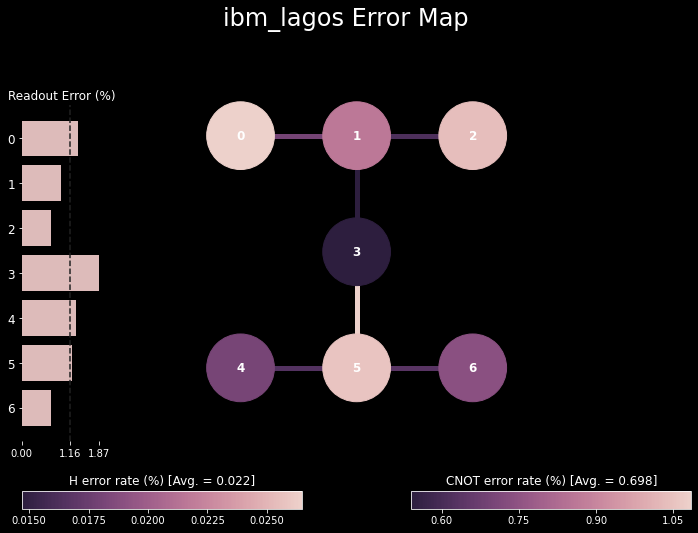

In [9]:
plot_error_map(backend)

In [10]:
qr = QuantumRegister(backend_config.num_qubits, 'q')
cr = ClassicalRegister(backend_config.num_qubits, 'c')
# initial_layout = [3, 5, 6] # runs 1-52
#initial_layout = [3, 1, 2] # runs 53-100, 103-135
#initial_layout = [2, 1, 0] # runs 136-192
#initial_layout = [4, 5, 6] # runs 101, 102
initial_layout = [6, 5, 4] # runs 192-
# initial_layout = [1, 2, 3] # testing on ibmq_bogota
native_gates = ['rz', 'sx', 'rzx', 'x', 'id']

In [22]:
avg_gate_error = 0
for ii in range(len(initial_layout)-1):
    q0 = initial_layout[ii]
    q1 = initial_layout[ii+1]
    avg_gate_error += backend.properties().gate_property('cx')[(q0, q1)]['gate_error'][0]

avg_gate_error /= len(initial_layout)-1
print('Avg 2-qubit gate error is '+str(avg_gate_error))

Avg 2-qubit gate error is 0.0062782402349440825


## Estimate Static $ZZ$ Rate

In [46]:
for ii in range(len(initial_layout)-1):
    q0 = initial_layout[ii]
    q0freq = backend.properties().qubit_property(q0)['frequency'][0]
    q0delta = backend.properties().qubit_property(q0)['anharmonicity'][0]
    q1 = initial_layout[ii+1]
    q1freq = backend.properties().qubit_property(q1)['frequency'][0]
    q1delta = backend.properties().qubit_property(q1)['anharmonicity'][0]
    detuning = q0freq - q1freq
    
    try:
        j_str = 'jq'+str(q0)+'q'+str(q1)
        JJ = backend_config.hamiltonian['vars'][j_str] / (2*np.pi)
    except:
        j_str = 'jq'+str(q1)+'q'+str(q0)
        JJ = backend_config.hamiltonian['vars'][j_str] / (2*np.pi)
        
    ZZ = -2*(JJ**2)*(q0delta + q1delta) / ((q1delta - detuning) * (q0delta + detuning))
    print('Static ZZ between q'+str(q0)+' and q'+str(q1)+' is: %f3.1 kHz' % (ZZ/1e3))

Static ZZ between q6 and q5 is: 137.9466933.1 kHz
Static ZZ between q5 and q4 is: 151.5755823.1 kHz


## Template Optimization and Basic Transpilation

In [12]:
trot_circ1 = transpile(trot_circ, optimization_level=0)
pass_ = TemplateOptimization(**rzx_templates.rzx_templates()) 
trot_circ2 = PassManager(pass_).run(trot_circ1)
trot_circ3 = transpile(trot_circ2, basis_gates=native_gates,
                      backend=backend, initial_layout=initial_layout)
#trot_circ3.draw(output='mpl', idle_wires=False)

## Bespoke Transpilation Time

So far, just doing one to combine consecutive gates. Does not look like modulo $2\pi$ is necessary here.

### Combine Consectutive Gates Pass

In [13]:
def combine_runs(dag: DAGNode, gate_str: str) -> DAGCircuit:
    runs = dag.collect_runs([gate_str])
    for run in runs:
        partition = []
        chunk = []
        for ii in range(len(run)-1):
            chunk.append(run[ii])

            qargs0 = run[ii].qargs
            qargs1 = run[ii+1].qargs

            if qargs0 != qargs1:
                partition.append(chunk)
                chunk = []

        chunk.append(run[-1])
        partition.append(chunk)

        # simplify each chunk in the partition
        for chunk in partition:
            theta = 0
            for ii in range(len(chunk)):
                theta += chunk[ii].op.params[0]

            # set the first chunk to sum of params
            chunk[0].op.params[0] = theta

            # remove remaining chunks if any
            if len(chunk) > 1:
                for nn in chunk[1:]:
                    dag.remove_op_node(nn)
    return dag

### Run Bespoke Passes

/Users/nick/anaconda3/envs/qiskit-dev/lib/python3.9/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


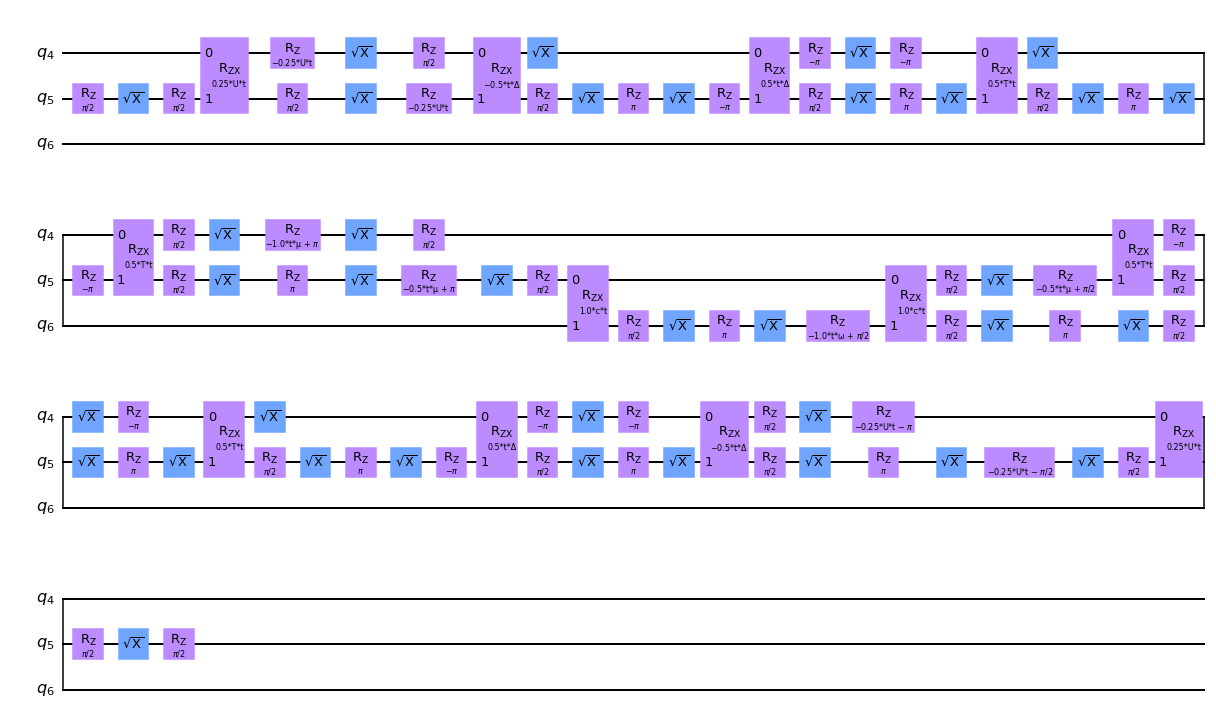

In [14]:
dag = circuit_to_dag(trot_circ3)
dag = combine_runs(dag, 'rz')
dag = combine_runs(dag, 'rzx')
trot_circ4 = dag_to_circuit(dag)
trot_circ4.draw(output='mpl', idle_wires=False)

## Pauli Twirling

This should suppress dynamical $ZZ$ (based on transmon/CR physics). We will focus on the case with the $R_{ZZ}(\theta)$ scaled cross resonance, in which elements from the set $\mathbb{G} = \{[I, I], [X, X], [Y, Y], [Z, Z]\}$ are placed both before and after the $R_{ZZ}$ since the resulting operators commute. <br>

~Nick thinks it should be easy to find a different set $\mathbb{G}$ for the $R_{ZX}$ scaled pulses found from template optimization, then write a transpiler pass that generates a circuit sampled by each pair of Pauli's. In this case, we should actually implement Pauli twirling *after* Pulse scaling.~ This is done now below. <br>

Someone [thought about this](https://github.com/Qiskit/qiskit-experiments/issues/482) for Qiskit Experiments, but apparently not too long. <br>

Note that this implementation of Pauli twirling is *different* than the one used in ["Scalable error mitigation for noisy quantum circuits produces competitive expectation values"](http://arxiv.org/abs/2108.09197)

### Convert Twirl Gates to $R_{ZX}$

In [15]:
# sanity to make sure we converted valid twirls
twirl_op = Z^X

twirls = [I^I, X^Z, Y^Y, Z^X]
for twirl in twirls:
    print((twirl @ twirl_op @ twirl) == twirl_op)

True
True
True
True


In [16]:
from qiskit.circuit.library import IGate, XGate, YGate, ZGate, RZXGate

twirl_gates = [[IGate(), IGate()],
               [XGate(), ZGate()],
               [YGate(), YGate()],
               [ZGate(), XGate()]]

### Convert Circuits to DAGs for Transpilation

In [17]:
dag = circuit_to_dag(trot_circ4)
#dag_drawer(dag)

In [18]:
def twirl_rzx_gates(dag: DAGCircuit, num_seeds: int) -> list:
    twirled_dags = []
    for seed in range(num_seeds):
        this_dag = deepcopy(dag)
        runs = this_dag.collect_runs(['rzx'])
        twirl_idxs = np.random.randint(0, len(twirl_gates), size=len(runs))
        for twirl_idx, run in enumerate(runs):
            mini_dag = DAGCircuit()
            p = QuantumRegister(2, 'p')
            mini_dag.add_qreg(p)
            mini_dag.apply_operation_back(twirl_gates[twirl_idxs[twirl_idx]][0], qargs=[p[0]])
            mini_dag.apply_operation_back(twirl_gates[twirl_idxs[twirl_idx]][1], qargs=[p[1]])
            mini_dag.apply_operation_back(run[0].op, qargs=[p[0], p[1]]) 
            mini_dag.apply_operation_back(twirl_gates[twirl_idxs[twirl_idx]][0], qargs=[p[0]])
            mini_dag.apply_operation_back(twirl_gates[twirl_idxs[twirl_idx]][1], qargs=[p[1]])

            rzx_node = this_dag.op_nodes(op=RZXGate).pop()
            this_dag.substitute_node_with_dag(node=rzx_node, input_dag=mini_dag, wires=[p[0], p[1]])

        twirled_dags.append(deepcopy(this_dag))
        
    return twirled_dags

### Perform Twirling

In [19]:
num_twirl_seeds = 4
dags = twirl_rzx_gates(dag, num_twirl_seeds)
#dag_drawer(dags[1])

In [20]:
trot_units = []
for dag in dags:
    trot_units.append(dag_to_circuit(dag))

## Game Plan
The above circuit is as transpiled as possible without binding parameters and adding the calibrations for the `RZXGate`s. This will form the unit of the sweeps we run.

# Build Sweep Experiment

In [21]:
#trot_unit = trot_circ4

exp_str = 'm_sweep' # or 't_sweep' or 'c_sweep' or 'y_sweep'

## Set Model Hamiltonian Parameters

Grouping by terms, the Model Hamiltonian is written as
$$
H_{\rm Pauli} = -\frac{2\mu + U}{4} (IZ + ZI) + \frac{t+\Delta}{2} XX + \frac{t-\Delta}{2} YY + \frac{U}{4} ZZ \\
\equiv m(IZ + IZ) + x XX + y YY + z ZZ
$$
negelecting the identity term. 

In [22]:
x_set = 1.5
# z_set = 0.2 # runs 1-4, 53-68, 209-224 (z semi-on!)
# z_set = 0.0 # runs 5-20, 69-84, 101-103, 115-, 225-240 (z off!)
z_set = 0.4 # runs 21-52 (z on!), 140- , 193-208
# z_set = -0.4 # runs 85-100 (z on and negative!)

### Invert Parameters before Binding

$$
t = x + y \qquad \Delta = x - y \qquad U = 4z \qquad \mu = -2(m+z)
$$

(This now happens differently in each param sweep step)

In [23]:
# job will choke on Parameter keys, convert to strings

def stringify(param_bind: dict) -> dict:
    param_bind_str = {}
    for key in param_bind.keys():
        param_bind_str[str(key)] = param_bind[key]
    
    return param_bind_str      

## $m$ Sweep Experiment

### Set Remaining Parameters

In [24]:
if exp_str == 'm_sweep':
    t_set = 5.0
    #dt_set = 1.2 # runs 5-36
    dt_set = 0.7 # runs 37-100, 140-
    #dt_set = 0.1 # runs 123-127
    c_set = 0.3
    
    # y_set = -1.5 # runs 1-4
    # y_set = -1.3 # runs 5-8
    # y_set = -1.1 # runs 9-12
    # y_set = -0.9 # runs 13-16
    # y_set = -0.7 # runs 17-20
    # y_set = -0.5 # runs 21-24
    # y_set = -0.3 # runs 25-28
    # y_set = -0.1 # runs 29-32
    # y_set = 0.1 # runs 33-36
    # y_set = 0.3 # runs 37-40
    # y_set = 0.5 # runs 41-44
    # y_set = 0.7 # runs 45-48
    # y_set = 0.9 # runs 49-52
    # y_set = 1.1 # runs, 53-56
    # y_set = 1.3 # runs 57-60
    y_set = 1.5 # runs 61-64

    U_set = 4*z_set

    param_bind = {UU: U_set, tt: dt_set, cc: c_set}
    # m_range = np.linspace(-1.5, -0.9, 4) # runs 1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61
    # m_range = np.linspace(-0.7, -0.1, 4) # runs 2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 51, 54, 58, 62
    # m_range = np.linspace(0.1, 0.7, 4) # runs 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63
    m_range = np.linspace(0.9, 1.5, 4) # runs 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60
    w_range = np.linspace(-3.5, 3.5, 51)

In [25]:
if exp_str == 'm_sweep':
    # Now let's add the circuits together
    NT = int(t_set/dt_set)
    trot_circs_total = []
    for trot_unit in trot_units:
        trot_circ_total = deepcopy(trot_unit)
        for ti in range (1, NT):
            trot_circ_total.append(trot_unit, qr)
            
        trot_circs_total.append(trot_circ_total)

    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for m_set in m_range:
        mu_set = -2*(m_set + z_set)
        T_set = x_set + y_set
        D_set = x_set - y_set
        
        param_bind[mu] = mu_set
        param_bind[TT] = T_set
        param_bind[DD] = D_set
        for w_set in w_range:
            for tidx, trot_circ_total in enumerate(trot_circs_total):
                circ_str = 'Freq sweep w='+str(round(w_set, 2))+ \
                    ', $\mu$ = '+str(round(mu_set, 2))+' , twirl '+str(tidx)
                bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
                temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                           metadata=stringify({**param_bind, ww: w_set}))
                temp_circ.append(bound_circ, qr)
                #temp_circ.measure(qr, cr)
                temp_circ.measure(qr[initial_layout[0]], cr[initial_layout[0]]) # runs 136-
                circ_w.append(temp_circ)
                param_decoder.append(['y='+str(round(y_set, 2))+', m=' + str(round(m_set, 2)) + 
                                  ', w=' + str(round(w_set, 2))+', twirl '+str(tidx)])

## Final Transpilation Steps

In [26]:
res_circ_scaled_trans = transpile(circ_w, backend, basis_gates=native_gates)
res_circ_digital_trans = transpile(circ_w, backend)

In [27]:
pass_ = RZXCalibrationBuilder(backend)
res_circ_scaled_trans1 = PassManager(pass_).run(res_circ_scaled_trans)

## Compare digital and scaled circuits

In [28]:
circ_num = -1
scaled_sched = schedule(res_circ_scaled_trans1[circ_num], backend)
basis_sched = schedule(res_circ_digital_trans[circ_num], backend)

### Count Operations

In [29]:
res_circ_scaled_trans1[circ_num].count_ops()

OrderedDict([('rz', 206), ('sx', 100), ('rzx', 84), ('x', 7), ('measure', 1)])

In [30]:
res_circ_digital_trans[circ_num].count_ops()

OrderedDict([('rz', 228), ('sx', 114), ('cx', 112), ('x', 14), ('measure', 1)])

In [31]:
dag = circuit_to_dag(res_circ_scaled_trans1[circ_num])
rzx_runs = dag.collect_runs(['rzx'])

est_fid_rzx = 1
for rzx_run in rzx_runs:
    angle = rzx_run[0].op.params[0]
    this_rzx_error = (abs(float(angle))/(np.pi/2))*avg_gate_error
    est_fid_rzx *= (1-this_rzx_error)
    
print('Scaled Circuit estimated fidelity is %2.f%%' % (est_fid_rzx*100))

Scaled Circuit estimated fidelity is 88%


In [32]:
num_cx = res_circ_digital_trans[circ_num].count_ops()['cx']
est_fid_dig = (1-avg_gate_error)**num_cx
print('Digital Circuit estimated fidelity is %2.f%%' % (est_fid_dig*100))

Digital Circuit estimated fidelity is 53%


### Look at Resulting Schedules

In [33]:
print('Scaled schedule takes '+str(scaled_sched.duration)+'dt')
print('Digital schedule takes '+str(basis_sched.duration)+'dt')

Scaled schedule takes 82368dt
Digital schedule takes 181664dt


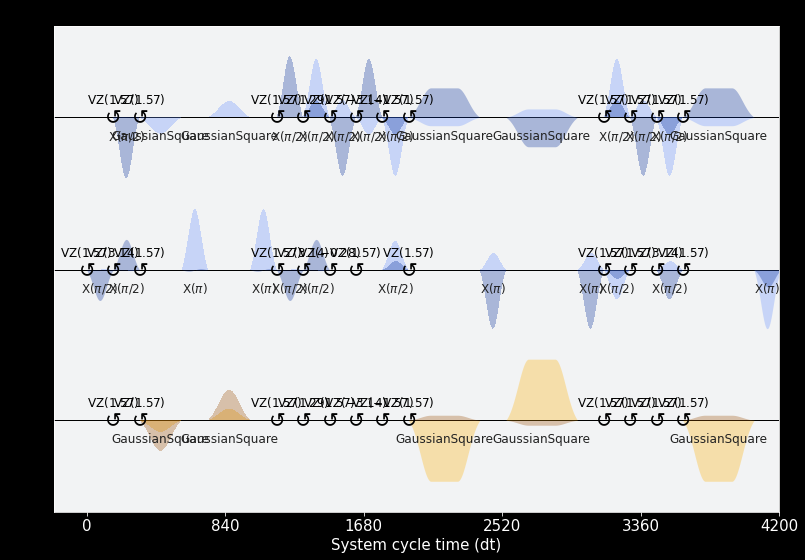

In [34]:
time_range=[0,4000]
scaled_sched.draw(time_range=time_range)

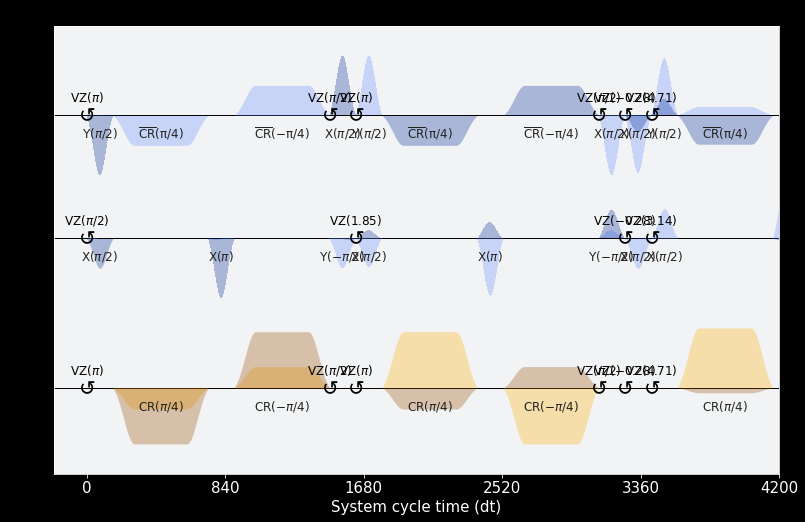

In [35]:
basis_sched.draw(time_range=time_range)

# Run on Quantum Hardware

In [ ]:
from qiskit.tools.monitor import job_monitor

if run_experiment:
    # run the job on a real backend
    job = backend.run(res_circ_scaled_trans1, job_name="SE_Eigensolver", meas_level=2, shots=2048) 

    
    print(job.job_id())
    job_monitor(job)

61e8e6deded89e4789a9db2e
Job Status: job is queued (1)     

## Or Retrieve from Previous Run

In [6]:

job_ids = [
            # z=0.4, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 6-5-4
            '61e6ef069307b98a466bec24', # run 1 - m_sweep -1.5 to -0.9, y=-1.5
            '61e6f2411faa069c4b3446c5', # run 2 - m_sweep -0.7 to -0.1, y=-1.5
            '61e6f60611d0378639abbb94', # run 3 - m_sweep 0.1 to 0.7, y=-1.5
            '61e6f923ded89e3d08a9d149', # run 4 - m_sweep 0.9 to 1.5, y=-1.5
    
            '61e6fe221faa063fe33446e8', # run 5 - m_sweep -1.5 to -0.9, y=-1.3
            '61e701e0dfe4a92a7722c4b1', # run 6 - m_sweep -0.7 to -0.1, y=-1.3
            '61e704e89847b3212eaaf8ab', # run 7 - m_sweep 0.1 to 0.7, y=-1.3
            '61e7077b4eebda3d9b7a7429', # run 8 - m_sweep 0.9 to 1.5, y=-1.3

            '61e70e4d11d0377f04abbc0c', # run 9 - m_sweep -1.5 to -0.9, y=-1.1
            '61e7fce79847b33260aafe11', # run 10 - m_sweep -0.7 to -0.1, y=-1.1
            '61e800684ddc9f024680c5cd', # run 11 - m_sweep 0.1 to 0.7, y=-1.1
            '61e8030fded89e3a55a9d6cf', # run 12 - m_sweep 0.9 to 1.5, y=-1.1

            '61e805ab9847b3fa8faafe2d', # run 13 - m_sweep -1.5 to -0.9, y=-0.9
            '61e8081c9847b32cabaafe35', # run 14 - m_sweep -0.7 to -0.1, y=-0.9
            '61e80a8adfe4a9623222cadf', # run 15 - m_sweep 0.1 to 0.7, y=-0.9
            '61e80d319847b3161baafe4a', # run 16 - m_sweep 0.9 to 1.5, y=-0.9

            '61e80fbe4eebda4bcf7a798e', # run 17 - m_sweep -1.5 to -0.9, y=-0.7
            '61e813ced6c095b5fedf9d54', # run 18 - m_sweep -0.7 to -0.1, y=-0.7
            '61e8170a4eebda880a7a79ac', # run 19 - m_sweep 0.1 to 0.7, y=-0.7
            '61e81d33dfe4a93ac822cb12', # run 20 - m_sweep 0.9 to 1.5, y=-0.7

            '61e829887f4bf87373bd3ed0', # run 21 - m_sweep -1.5 to -0.9, y=-0.5
            '61e82dd0dfe4a94e2f22cb65', # run 22 - m_sweep -0.7 to -0.1, y=-0.5
            '61e8307d4ddc9f515c80c6a4', # run 23 - m_sweep 0.1 to 0.7, y=-0.5
            '61e8343f6fb797d51f4414b9', # run 24 - m_sweep 0.9 to 1.5, y=-0.5

            '61e837544eebda03d67a7a4c', # run 25 - m_sweep -1.5 to -0.9, y=-0.3
            '61e83a356fb7973ff44414d0', # run 26 - m_sweep -0.7 to -0.1, y=-0.3
            '61e83daa9847b34c3caaff3b', # run 27 - m_sweep 0.1 to 0.7, y=-0.3
            '61e8406ad6c0953d89df9e31', # run 28 - m_sweep 0.9 to 1.5, y=-0.3

            '61e8434eded89e5892a9d7ea', # run 29 - m_sweep -1.5 to -0.9, y=-0.1
            '61e845a7404aae435d437486', # run 30 - m_sweep -0.7 to -0.1, y=-0.1
            '61e848af9847b39d4daaff73', # run 31 - m_sweep 0.1 to 0.7, y=-0.1
            '61e84cd8d6c0958888df9eaa', # run 32 - m_sweep 0.9 to 1.5, y=-0.1

            '61e851b71faa068030344e41', # run 33 - m_sweep -1.5 to -0.9, y=0.1
            '61e855d34ddc9f19ab80c79c', # run 34 - m_sweep -0.7 to -0.1, y=0.1
            '61e85a224eebda6edb7a7b32', # run 35 - m_sweep 0.1 to 0.7, y=0.1
            '61e863449847b380d5ab0036' ,# run 36 - m_sweep 0.9 to 1.5, y=0.1

            '61e866ce9847b3fa38ab0046', # run 37 -  m_sweep -1.5 to -0.9, y=0.3
            '61e86dcb4eebda024c7a7b92', # run 38 - m_sweep -0.7 to -0.1, y=0.3
            '61e8709b6fb7976499441616', # run 39 - m_sweep 0.1 to 0.7, y=0.3
            '61e873744eebda31eb7a7bb5', # run 40 - m_sweep 0.9 to 1.5, y=0.3

            '61e881a7404aae63764375f3', # run 41 - m_sweep -1.5 to -0.9, y=0.5
            '61e88ee8d6c0952d2adf9fcd', # run 42 - m_sweep -0.7 to -0.1, y=0.5
            '61e891cedfe4a9367022cda8', # run 43 - m_sweep 0.1 to 0.7, y=0.5
            '61e894b51faa06945f344f9e', # run 44 - m_sweep 0.9 to 1.5, y=0.5

            '61e897486fb7970b744416d9', # run 45 - m_sweep -1.5 to -0.9, y=0.7
            '61e89a1a1faa06c4cf344fbb', # run 46 - m_sweep -0.7 to -0.1, y=0.7
            '61e89ebaded89edaeca9da08', # run 47 - m_sweep 0.1 to 0.7, y=0.7
            '61e8a62f1faa06dcce344ff1', # run 48 - m_sweep 0.9 to 1.5, y=0.7

            '61e8b5931faa065c4d34502f', # run 49 - m_sweep -1.5 to -0.9, y=0.9
            '61e8b8291faa068e9f34503c', # run 50 - m_sweep -0.7 to -0.1, y=0.9
            '61e8bbb3dfe4a925e022ce61', # run 51 - m_sweep 0.1 to 0.7, y=0.9
            '61e8bec6ded89e419aa9da64', # run 52 - m_sweep 0.9 to 1.5, y=0.9

            '61e8c1e4dfe4a94a8d22ce7b', # run 53 - m_sweep -1.5 to -0.9, y=1.1
            '61e8cba54eebda4bc77a7d47', # run 54 - m_sweep -0.7 to -0.1, y=1.1
            '61e8ceae7f4bf80fcabd421a', # run 55 - m_sweep 0.1 to 0.7, y=1.1
            '61e8d28b6fb7971a9c4417e7', # run 56 - m_sweep 0.9 to 1.5, y=1.1

            '61e8d5124ddc9f28ba80c9ca', # run 57 - m_sweep -1.5 to -0.9, y=1.3
            '61e8d826dfe4a91e9822cf10', # run 58 - m_sweep -0.7 to -0.1, y=1.3
            '61e8dabbdfe4a9547622cf1c', # run 59 - m_sweep 0.1 to 0.7, y=1.3
            '61e8dd5c9847b35e22ab0286', # run 60 - m_sweep 0.9 to 1.5, y=1.3

            '61e8dfc14ddc9f78ee80c9f5', # run 61 - m_sweep -1.5 to -0.9, y=1.5
            '61e8e22f4ddc9f0e5f80ca01', # run 62 - m_sweep -0.7 to -0.1, y=1.5
            '61e8e4889847b3ef35ab02a2', # run 63 - m_sweep 0.1 to 0.7, y=1.5
            '61e8e6deded89e4789a9db2e'] # run 64 - m_sweep 0.9 to 1.5, y=1.5

In [8]:
run_num = 64
job = backend.retrieve_job(job_ids[run_num-1])

In [5]:
c_set = 0.3
dt_set = 0.7
t_set = 5
x_set = 1.5
z_set = 0.4
num_twirl_seeds = 4
num_shots = 8192
w_range = np.linspace(-3.5, 3.5, 51)


### Check Parameters Agree with Job Metadata

In [6]:
y_set = 1.3
# m_sweep = np.linspace(-1.5, -0.9, 4)
# m_sweep = np.linspace(-0.7, -0.1, 4)
# m_sweep = np.linspace(0.1, 0.7, 4)
m_sweep = np.linspace(0.9, 1.5, 4)

job = ntb_twirl_job60
Result = job.result().get_counts()

for midx, m_set in enumerate(m_sweep):
    jidx0 = num_twirl_seeds*midx*len(w_range)
    mu_set = -2*(m_set + z_set)
    T_set = x_set + y_set
    D_set = x_set - y_set
    
    metadata = job.result().results[jidx0].header.metadata
    shots = job.result().results[jidx0].shots
    if (mu_set == metadata['μ']) and (T_set == metadata['T']) and \
        (D_set == metadata['Δ']) and (shots*num_twirl_seeds == num_shots) and \
        (c_set == metadata['c']) and (dt_set == metadata['t']):
        print('Parameter agreement')
    else:
        print('Parameter mismatch!')

Parameter agreement
Parameter agreement
Parameter agreement
Parameter agreement


## Save Data

In [384]:
save_data = False

for midx, m_set in enumerate(m_sweep):
    P0_w = []
    param_decoder = []
    for wi in range(len(w_range)):
        P0 = 0
        for tidx in range(num_twirl_seeds):
            jidx0 = num_twirl_seeds*midx*len(w_range) + tidx
            #print(wi*num_twirl_seeds + jidx0)
            
            keys = list(Result[wi*num_twirl_seeds + jidx0].keys())
            norm = sum([Result[wi*num_twirl_seeds + jidx0][key] for key in keys]) 

            for key in keys:
                if key == '0000000':
                    P0 += Result[wi*num_twirl_seeds + jidx0][key]/norm

        P0_w.append(P0/num_twirl_seeds)
        
        param_decoder.append(['y='+str(round(y_set, 2))+', m=' + str(round(m_set, 2)) + 
                                  ', w=' + str(round(wi, 2))])

    if save_data:
        w0 = w_range[0]
        dw = round(w_range[1] - w_range[0], 2)
        np.save('../data/final-sweeps/2site/z0p4_twirl/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set), P0_w)
        np.save('../data/final-sweeps/2site/z0p4_twirl/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set), w_range)
        np.save('../data/final-sweeps/2site/z0p4_twirl/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set), param_decoder)
   

### Plot Data

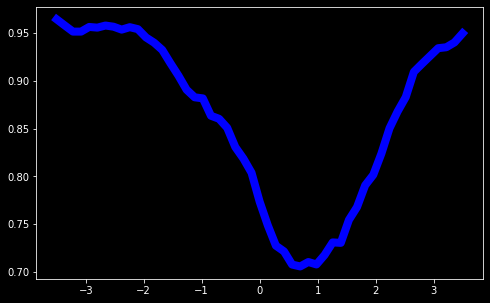

In [385]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(w_range, P0_w, label='Twirled Sweep', linewidth=8, color='b')

# Qiskit Version Table

In [386]:
import qiskit.tools.jupyter
%qiskit_version_table